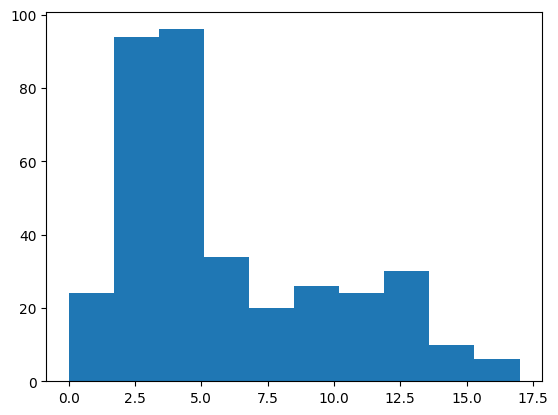

In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)
demand_hist = []
for i in range(52):
    for j in range(4):
        random_demand = np.random.normal(3, 1.5)
        if random_demand < 0:
            random_demand = 0
        random_demand = np.round(random_demand)
        demand_hist.append(random_demand)
    random_demand = np.random.normal(6, 1)
    if random_demand < 0:
        random_demand = 0
    random_demand = np.round(random_demand)
    demand_hist.append(random_demand)
    for j in range(2):
        random_demand = np.random.normal(12, 2)
        if random_demand < 0:
            random_demand = 0
        random_demand = np.round(random_demand)
        demand_hist.append(random_demand)
plt.hist(demand_hist)

In [3]:
class InvOptEnv():
    def __init__(self, demand_records):
        self.n_period = len(demand_records)
        self.current_period = 1
        self.day_of_week = 0
        self.inv_level = 25
        self.inv_pos = 25 #inventory_on_hand + up_coming_order
        self.capacity = 50 #maximum capacity
        self.holding_cost = 3
        self.unit_price = 30
        self.fixed_order_cost = 50
        self.variable_order_cost = 10
        self.lead_time = 2
        self.order_arrival_list = []
        self.demand_list = demand_records
        self.state = np.array([self.inv_pos] + self.convert_day_of_week(self.day_of_week))
        self.state_list = []
        self.state_list.append(self.state)
        self.action_list = []
        self.reward_list = []
            
    def reset(self):
        '''reset the environment'''
        self.state_list = []
        self.action_list = []
        self.reward_list = []
        self.inv_level = 25
        self.inv_pos = 25
        self.current_period = 1
        self.day_of_week = 0
        self.state = np.array([self.inv_pos] + self.convert_day_of_week(self.day_of_week))
        self.state_list.append(self.state)
        self.order_arrival_list = []
        return self.state
        
    def step(self, action):
        '''action: the order quantity '''
        if action > 0:
            y = 1
            self.order_arrival_list.append([self.current_period+self.lead_time, action])
        else:
            y = 0
        if len(self.order_arrival_list) > 0:
            if self.current_period == self.order_arrival_list[0][0]:
                self.inv_level = min(self.capacity, self.inv_level + self.order_arrival_list[0][1]) #update tinh trang kho
                self.order_arrival_list.pop(0) # van chuyen xong 1 don hang
        demand = self.demand_list[self.current_period-1] #demand tu khach hang
        units_sold = demand if demand <= self.inv_level else self.inv_level #san luong ban ra
        reward = units_sold*self.unit_price-self.holding_cost*self.inv_level - y*self.fixed_order_cost \
                 -action*self.variable_order_cost    # ham reward nhan duoc
        self.inv_level = max(0,self.inv_level-demand) #update tinh trang kho
        self.inv_pos = self.inv_level #update tinh trang kho: on_hand+up_coming nma da chuyen xong nen up_coming=0
        if len(self.order_arrival_list) > 0:
            for i in range(len(self.order_arrival_list)):
                self.inv_pos += self.order_arrival_list[i][1] #update lai tinh trang kho: on_hand+up_coming
        self.day_of_week = (self.day_of_week+1)%7
        self.state = np.array([self.inv_pos] +self.convert_day_of_week(self.day_of_week))
        self.current_period += 1
        self.state_list.append(self.state)
        self.action_list.append(action)
        self.reward_list.append(reward)
        if self.current_period > self.n_period:
            terminate = True
        else: 
            terminate = False
        return self.state, reward, terminate
    
    def convert_day_of_week(self,d):
        if d == 0:
            return [0, 0, 0, 0, 0, 0]
        if d == 1:
            return [1, 0, 0, 0, 0, 0] 
        if d == 2:
            return [0, 1, 0, 0, 0, 0] 
        if d == 3:
            return [0, 0, 1, 0, 0, 0] 
        if d == 4:
            return [0, 0, 0, 1, 0, 0] 
        if d == 5:
            return [0, 0, 0, 0, 1, 0] 
        if d == 6:
            return [0, 0, 0, 0, 0, 1] 

In [6]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """ Actor (Policy) Model."""
    def __init__(self, state_size, action_size, seed, fc1_unit=128,
                 fc2_unit = 128):
        """
        Initialize parameters and build model.
        Params
        =======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_unit (int): Number of nodes in first hidden layer
            fc2_unit (int): Number of nodes in second hidden layer
        """
        super(QNetwork,self).__init__() ## calls __init__ method of nn.Module class
        self.seed = torch.manual_seed(seed)
        self.fc1= nn.Linear(state_size,fc1_unit)
        self.fc2 = nn.Linear(fc1_unit,fc2_unit)
        self.fc3 = nn.Linear(fc2_unit,action_size)
        
    def forward(self,x):
        # x = state
        """
        Build a network that maps state -> action values.
        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

import random 
from collections import namedtuple, deque 

##Importing the model (function approximator for Q-table)
# from model import QNetwork

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler 

BUFFER_SIZE = int(5*1e5)  #replay buffer size
BATCH_SIZE = 128      # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3             # for soft update of target parameters
LR = 1e-4            # learning rate
UPDATE_EVERY = 4      # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns form environment."""
    
    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        =======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        
        #Q- Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(),lr=LR)
        
        # Replay memory 
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE,BATCH_SIZE,seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        
    def step(self, state, action, reward, next_step, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_step, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step+1)% UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get radom subset and learn

            if len(self.memory)>BATCH_SIZE:
                experience = self.memory.sample()
                self.learn(experience, GAMMA)
        
    def act(self, state, eps = 0):
        """Returns action for given state as per current policy
        Params
        =======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        #Epsilon -greedy action selction
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
            
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        =======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        ## TODO: compute and minimize the loss
        criterion = torch.nn.MSELoss()
        # Local model is one which we need to train so it's in training mode
        self.qnetwork_local.train()
        # Target model is one with which we need to get our target so it's in evaluation mode
        # So that when we do a forward pass with target model it does not calculate gradient.
        # We will update target model weights with soft_update function
        self.qnetwork_target.eval()
        #shape of output from the model (batch_size,action_dim) = (64,4)
        
        predicted_targets = self.qnetwork_local(states).gather(1,actions)
        with torch.no_grad():
            labels_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        # .detach() ->  Returns a new Tensor, detached from the current graph.
        labels = rewards + (gamma* labels_next*(1-dones))
        loss = criterion(predicted_targets,labels).to(device)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local,self.qnetwork_target,TAU)
            
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        =======
            local model (PyTorch model): weights will be copied from
            target model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(),
                                           local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1-tau)*target_param.data)
            
class ReplayBuffer:
    """Fixed -size buffe to store experience tuples."""
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experiences = namedtuple("Experience", field_names=["state",
                                                               "action",
                                                               "reward",
                                                               "next_state",
                                                               "done"])
        self.seed = random.seed(seed)
        
    def add(self,state, action, reward, next_state,done):
        """Add a new experience to memory."""
        e = self.experiences(state,action,reward,next_state,done)
        self.memory.append(e)
        
    def sample(self):
        """Randomly sample a batch of experiences from memory"""
    
        experiences = random.sample(self.memory,k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states,actions,rewards,next_states,dones)
    
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

episode50: -24833.0
episode100: -5068.0
episode150: 3334.0
episode200: 8252.0


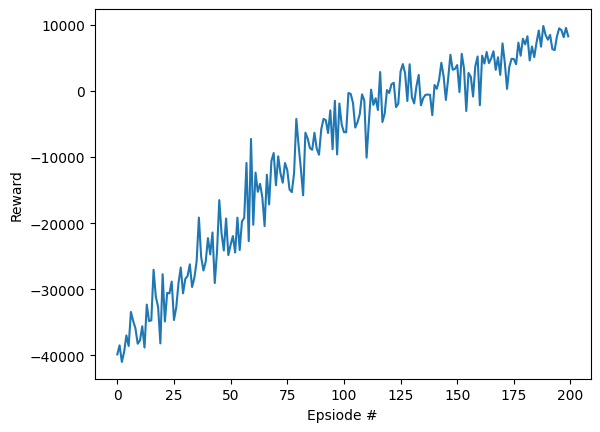

In [8]:
agent = Agent(state_size=7,action_size=21,seed=0)

def dqn(env, n_episodes= 1000, max_t = 10000, eps_start=1.0, eps_end = 0.01,
       eps_decay=0.995):
    """Deep Q-Learning
    
    Params
    ======
        n_episodes (int): maximum number of training epsiodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon 
        eps_decay (float): mutiplicative factor (per episode) for decreasing epsilon
        
    """
    scores = [] # list containing score from each episode
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state,eps)
            next_state,reward,done = env.step(action)
            agent.step(state,action,reward,next_state,done)
            ## above step decides whether we will train(learn) the network
            ## actor (local_qnetwork) or we will fill the replay buffer
            ## if len replay buffer is equal to the batch size then we will
            ## train the network or otherwise we will add experience tuple in our 
            ## replay buffer.
            state = next_state
            score += reward
            if done:
                if i_episode %50 == 0:
                    print('episode'+str(i_episode)+':', score)
                scores.append(score)
                break
        eps = max(eps*eps_decay,eps_end)## decrease the epsilon
    return scores

env = InvOptEnv(demand_hist)
scores= dqn(env,n_episodes=200)

plt.plot(np.arange(len(scores)),scores)
plt.ylabel('Reward')
plt.xlabel('Epsiode #')
plt.show()
plt.savefig('episode_reward fig')
torch.save(agent.qnetwork_local.state_dict(), 'fig_2.txt')